## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates
df_cap.set_index('date',inplace=True)
df_cap=np.log(df_cap)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,25.989854,24.608140,24.432446,24.319501,25.679313,25.789749,24.845338,24.231041,25.826199,25.211647,...,23.965790,25.752110,25.908282,24.027028,24.324363,24.930283,24.445025,25.272255,26.054174,26.513870
2010-01-05,25.991581,24.605938,24.464673,24.331386,25.674848,25.796807,24.842841,24.274628,25.831364,25.229172,...,23.969760,25.737744,25.908609,24.003053,24.322776,24.915232,24.433500,25.274056,26.044167,26.517767
2010-01-06,25.975547,24.621973,24.494556,24.334420,25.668318,25.796933,24.837513,24.292189,25.826199,25.218442,...,23.963645,25.734523,25.903855,23.988763,24.332575,24.909975,24.419980,25.230531,26.041929,26.526373
2010-01-07,25.973697,24.633714,24.534240,24.338450,25.672812,25.793158,24.837827,24.292834,25.876683,25.237821,...,23.987989,25.730753,25.898417,24.003053,24.370234,24.914240,24.429244,25.224561,26.042489,26.523226
2010-01-08,25.980323,24.632999,24.524547,24.349616,25.678098,25.794922,24.839396,24.296371,25.897993,25.218729,...,23.986013,25.738815,25.897094,24.001613,24.360798,24.916224,24.432007,25.225191,26.037439,26.519207


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

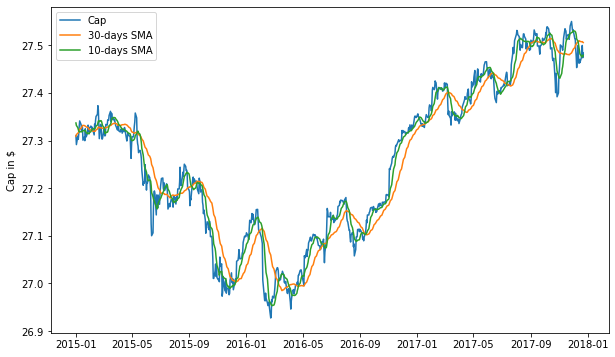

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [7]:
# Centring and scaling the data else there are issues with convergence

mean_df_cap = df_cap.sum(axis=1).mean()
df_cap_scaled = df_cap/mean_df_cap

#Scaling
short_rolling  = short_rolling/mean_df_cap
short_rolling /= short_rolling.loc[short_rolling.first_valid_index()]
long_rolling   = long_rolling/mean_df_cap
long_rolling  /= long_rolling.loc[long_rolling.first_valid_index()]

#PCT change
df_cap_refined        = df_cap_scaled.pct_change(periods=1).shift(-1)
short_rolling_refined = short_rolling.pct_change(periods=1).shift(-1)
long_rolling_refined  = long_rolling.pct_change(periods=1).shift(-1)

In [8]:
# Remove Nans and allign data
def organize(x, z1, z2):
    z1.dropna(inplace=True)
    z2.dropna(inplace=True)
    x  = x[x.index.isin(z1.index) & x.index.isin(z2.index)]
    z1 = z1[z1.index.isin(x.index)]
    z2 = z2[z2.index.isin(x.index)]
    return x, z1, z2

xr, z1r, z2r= organize(df_cap_scaled, short_rolling_refined, long_rolling_refined)


In [9]:
expy=np.exp(xr)
exp2y=np.exp(2*xr)
exp2y

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-02-12,1.069975,1.066181,1.066131,1.065394,1.069168,1.069332,1.066805,1.065149,1.069761,1.067679,...,1.064448,1.069266,1.069946,1.064613,1.065474,1.066946,1.065741,1.067742,1.070258,1.071458
2010-02-15,1.069964,1.066141,1.066156,1.065412,1.069163,1.069326,1.066840,1.065175,1.069780,1.067677,...,1.064484,1.069258,1.069947,1.064621,1.065554,1.066989,1.065758,1.067738,1.070284,1.071436
2010-02-16,1.069969,1.066148,1.066204,1.065427,1.069187,1.069356,1.066855,1.065251,1.069795,1.067650,...,1.064482,1.069267,1.069971,1.064637,1.065566,1.067020,1.065775,1.067739,1.070253,1.071444
2010-02-17,1.069952,1.066142,1.066234,1.065457,1.069196,1.069372,1.066873,1.065237,1.069789,1.067658,...,1.064478,1.069308,1.069973,1.064644,1.065501,1.067037,1.065771,1.067727,1.070254,1.071440
2010-02-18,1.069934,1.066133,1.066251,1.065447,1.069189,1.069331,1.066864,1.065250,1.069803,1.067667,...,1.064476,1.069302,1.069972,1.064653,1.065599,1.067032,1.065774,1.067725,1.070272,1.071420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-15,1.074232,1.067587,1.070049,1.067849,1.070167,1.070395,1.069368,1.069291,1.068632,1.068089,...,1.067757,1.070318,1.070133,1.065473,1.070340,1.068235,1.070383,1.070126,1.070851,1.071427
2017-12-18,1.074261,1.067640,1.070120,1.067871,1.070192,1.070459,1.069390,1.069348,1.068634,1.068125,...,1.067867,1.070367,1.070170,1.065517,1.070433,1.068267,1.070402,1.070146,1.070892,1.071495
2017-12-19,1.074314,1.067665,1.070092,1.067874,1.070180,1.070451,1.069432,1.069364,1.068666,1.068148,...,1.067938,1.070402,1.070191,1.065550,1.070485,1.068286,1.070416,1.070171,1.070905,1.071490


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Running:
Iteration count, Loss = 1 , 7062315000.0
Iteration count, Loss = 501 , 149728030.0
Iteration count, Loss = 1001 , 85942240.0
Iteration count, Loss = 1501 , 58374790.0
Iteration count, Loss = 2001 , 42635690.0
Iteration count, Loss = 2501 , 32322228.0
Iteration count, Loss = 3001 , 24962128.0
Iteration count, Loss = 3501 , 19442194.0
Iteration count, Loss = 4001 , 15169574.0
Iteration count, Loss = 4501 , 11749894.0
Iteration count, Loss = 5001 , 9001269.0
Iteration count, Loss = 5501 , 6782659.5
Iteration count, Loss = 6001 , 4973967.5
Iteration count, Loss = 6501 , 3516191.0
Iteration count, Loss = 7001 , 2349102.5
Iteration count, Loss = 7501 , 1465623.9
Iteration count, Loss = 8001 , 776245.06
Iteration count, Loss = 8501 , 345777.84
Iteration count, Loss = 9001 , 5573.637
Iteration count, Loss = 9501 , -184974.7
Maximum iterations exceeded
-------------------- 
 Results 
         kap   sigma  

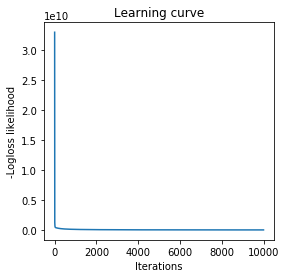

In [10]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tf.disable_eager_execution()

def model(X, signal1, signal2, e1, e2, lr = 0.001):

    results     = pd.DataFrame([],index=X.columns,columns=['kap','sigma','w1','w2','theta','g'])
    max_i       = 10000
    tolerance   = 1e-15
    LAMBDA_REG  = 0.01
    N           = X.shape[1] 

    tf.reset_default_graph()
    x     = tf.placeholder(shape=(None,N),dtype=tf.float32,name="x")   
    z1    = tf.placeholder(shape=(None,N),dtype=tf.float32,name="z1")   
    z2    = tf.placeholder(shape=(None,N),dtype=tf.float32,name="z2") 
    expy  = tf.placeholder(shape=(None,N),dtype=tf.float32,name="expy") 
    exp2y = tf.placeholder(shape=(None,N),dtype=tf.float32,name="exp2y") 
    kap   = tf.get_variable("kap",initializer=tf.random_uniform([N],minval=0.,maxval=1.0)) 
    sigma = tf.get_variable("sigma",initializer=tf.random_uniform([N],minval=0.,maxval=0.05))
    #new
    theta = tf.get_variable("theta",initializer=tf.random_uniform([N],minval=0.,maxval=0.50))
    g = tf.get_variable("g",initializer=tf.random_uniform([N],minval=0.,maxval=0.50))

    w1_init = tf.random_normal([N],mean=0.5,stddev=0.1)
    w2_init = 1 - w1_init
    w1      = tf.get_variable("w1",initializer=w1_init) 
    w2      = tf.get_variable("w2",initializer=w2_init) 
    W1      = w1*tf.ones(N)
    W2      = w2*tf.ones(N)
    mu      = tf.zeros([N])
    Sigma   = sigma*tf.ones([N])
    wz1     = tf.multiply(W1,z1)
    wz2     = tf.multiply(W2,z2)
    scale   = tf.slice(x,[0,0],[1,-1])
    wz      = tf.multiply(scale,tf.cumprod(1+tf.add(wz1,wz2)))
    kap     = kap*tf.ones([N])
    theta   = theta*tf.ones([N])
    g       = g*tf.ones([N])

    #r        = tf.divide(tf.subtract(tf.manip.roll(x,shift=-1,axis=0),x),x)
    r        = tf.subtract(tf.manip.roll(x,shift=-1,axis=0),x)
    k_term   = tf.multiply(kap,expy)
    g_term   = tf.multiply(g,exp2y)
    mix_term = -1*tf.subtract(theta,tf.subtract(tf.multiply(0.5*Sigma,Sigma),wz))
    #v        = tf.subtract(r, tf.multiply(kap, tf.subtract(wz,x)))
    v        = tf.add(r,tf.add(mix_term,tf.add(k_term,g_term)))
    v        = tf.slice(v,[0,0],[tf.shape(v)[0]-1,-1])
    
    dist     = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
    log_prob = dist.log_prob(v)
    reg_term = tf.reduce_sum(tf.square(w1+w2-1)) # L2 norm
    
    neg_log_likelihood = -tf.reduce_sum(log_prob) + LAMBDA_REG*reg_term
    optimizer          = tf.train.AdamOptimizer(learning_rate=lr)
    train_op           = optimizer.minimize(neg_log_likelihood)

    # run a TensorFlow session
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())    
        losses = sess.run([neg_log_likelihood], feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
        i=1
        print("Running:")
        
        while True:
    
            sess.run(train_op, feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
            new_loss = sess.run(neg_log_likelihood, feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
            loss_diff = np.abs(new_loss - losses[-1])
            losses.append(new_loss)
        
            if i%500==1:
                print("Iteration count, Loss = " + str(i) + " , " + str(new_loss))
        
            if loss_diff < tolerance:
                print('Convergence in {} iterations'.format(i))
                break

            if i >= max_i:
                print('Maximum iterations exceeded')
                break

            i += 1

        results['kap'],results['sigma'],results['w1'],results['w2'],results['theta'],results['g'] = sess.run(kap),sess.run(sigma),sess.run(W1),sess.run(W2),sess.run(theta),sess.run(g)
        fitted_means = sess.run(wz, feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
        mean_levels = pd.DataFrame(fitted_means,index=X.index,columns=X.columns)
        
    print("-------------------- ")
    print(" Results ")
    print(results.round(4))

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(losses)
    plt.title('Learning curve')
    plt.xlabel('Iterations')
    plt.ylabel('-Logloss likelihood')
 
    plt.show()
    return results, mean_levels, losses


results1, mean1, loss1 = model(X=xr, signal1=z1r, signal2=z2r, e1=expy, e2=exp2y , lr=0.0001) 

In [12]:
def compare_plots(actual_price, predicted_price):

    avg_mkt_cap = actual_price.sum(axis=1).mean()

    N = actual_price.shape[1]
    plt.figure(figsize=(15,N))
    plt.suptitle('actual_price vs model prediction',size=15)
    stocks = actual_price.columns[:N]
    for index, stock in enumerate(stocks,1):
        plt.subplot(math.ceil(N/3),3,index)
        plt.plot(actual_price.loc[:][stock],color='red',label='Actual Price')
        plt.plot(avg_mkt_cap*predicted_price.loc[:][stock],color='green',label='Model Prediction')
        plt.title(stock,size=10)
        plt.xticks([])
    
    plt.show()

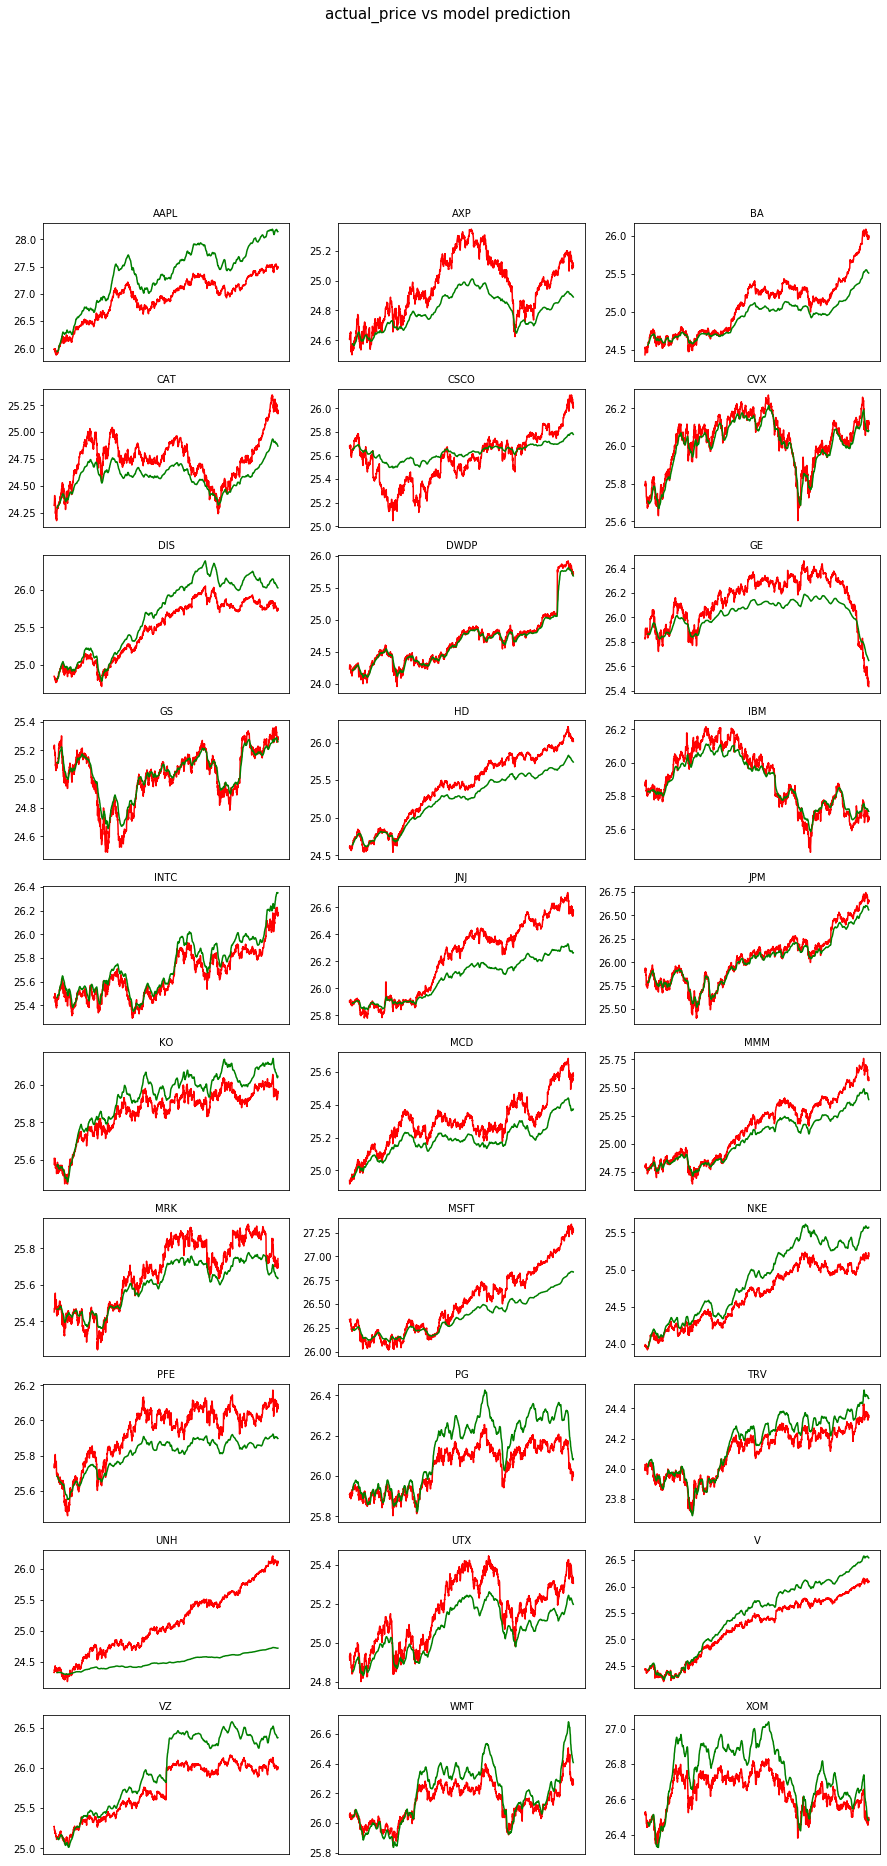

In [13]:
compare_plots(df_cap, mean1)

We hence create a model using moving average as the signal and the given V function. The function converges but there are still visible innaccuracies though it does succesfully capture the direction of movement (increase or decrease correctly - as it appears)

## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [14]:
# Put the rest of your code and analysis for Part 2 here.
def defrate(X, signal1, signal2, e1, e2):

    results     = pd.DataFrame([],index=X.columns,columns=['r','vb-va','sigma square by 2'])
    N           = X.shape[1] 

    tf.reset_default_graph()
    x     = tf.placeholder(shape=(None,N),dtype=tf.float32,name="x")   
    z1    = tf.placeholder(shape=(None,N),dtype=tf.float32,name="z1")   
    z2    = tf.placeholder(shape=(None,N),dtype=tf.float32,name="z2") 
    expy  = tf.placeholder(shape=(None,N),dtype=tf.float32,name="expy") 
    exp2y = tf.placeholder(shape=(None,N),dtype=tf.float32,name="exp2y") 
    kap   = tf.get_variable("kap",initializer=tf.random_uniform([N],minval=0.,maxval=1.0)) 
    sigma = tf.get_variable("sigma",initializer=tf.random_uniform([N],minval=0.,maxval=0.05))
    #new
    theta = tf.get_variable("theta",initializer=tf.random_uniform([N],minval=0.,maxval=0.50))
    g = tf.get_variable("g",initializer=tf.random_uniform([N],minval=0.,maxval=0.50))

    w1_init = tf.random_normal([N],mean=0.5,stddev=0.1)
    w2_init = 1 - w1_init
    w1      = tf.get_variable("w1",initializer=w1_init) 
    w2      = tf.get_variable("w2",initializer=w2_init) 
    W1      = w1*tf.ones(N)
    W2      = w2*tf.ones(N)
    mu      = tf.zeros([N])
    Sigma   = sigma*tf.ones([N])
    wz1     = tf.multiply(W1,z1)
    wz2     = tf.multiply(W2,z2)
    scale   = tf.slice(x,[0,0],[1,-1])
    wz      = tf.multiply(scale,tf.cumprod(1+tf.add(wz1,wz2)))
    kap     = kap*tf.ones([N])
    theta   = theta*tf.ones([N])
    g       = g*tf.ones([N])

    k_term   = tf.multiply(kap,expy)
    g_term   = tf.multiply(0.5*g,exp2y)
    g_term2  = 2*g_term
    mix_term = tf.multiply(-1*tf.subtract(theta,tf.subtract(tf.multiply(0.5*Sigma,Sigma),wz)),x)
    v        = tf.add(mix_term,tf.add(k_term,g_term))
    v2       = tf.add(k_term,g_term)
    v        = tf.slice(v,[0,0],[tf.shape(v)[0]-1,-1])
    v2       = tf.slice(v2,[0,0],[tf.shape(v2)[0]-1,-1])
    vmax     = tf.reduce_max(v,0)
    vmin     = tf.reduce_min(v,0)
    b        = tf.argmax(v,0)
    a        = tf.argmin(v,0)
    
    flat_v2   = tf.reshape(v2, [-1])  # Reshape to a vector.

    # N.B. Handles 2-D case only.
    flat_ind_max = b + tf.cast(tf.range(tf.shape(v2)[1]) * tf.shape(v2)[0], tf.int64)
    flat_ind_min = a + tf.cast(tf.range(tf.shape(v2)[1]) * tf.shape(v2)[0], tf.int64)
    v2max_ = tf.gather(flat_v2, flat_ind_max)
    v2min_ = tf.gather(flat_v2, flat_ind_min)
    r      = tf.multiply(0.5/math.pi*tf.sqrt(tf.multiply(tf.abs(v2max_),tf.abs(v2min_))),tf.exp(-2*tf.divide(tf.subtract(vmax,vmin),tf.multiply(Sigma,Sigma))))
    #r= tf.pow(r,252)
    sigma_sq = tf.multiply(0.5*Sigma,Sigma)
    vbva  = tf.subtract(vmax,vmin)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #sess.run(wz, feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
        results['r']=sess.run(r,feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
        results['vb-va']=sess.run(vbva,feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
        results['sigma square by 2']=sess.run(sigma_sq,feed_dict={x: X, z1: signal1, z2: signal2, expy:e1, exp2y:e2})
        return results
results3 = defrate(X=xr, signal1=z1r, signal2=z2r, e1=expy, e2=exp2y) 
results3

,r,vb-va,sigma square by 2
AAPL,8.384257e-10,0.001244,0.000070
AXP,1.107617e-01,0.000368,0.001020
BA,3.144595e-03,0.001417,0.000368
CAT,0.000000e+00,0.001156,0.000002
CSCO,5.633834e-02,0.000412,0.001127
CVX,6.161710e-02,0.000192,0.000240
DIS,3.658153e-02,0.000555,0.000409
DWDP,1.740982e-05,0.002279,0.000262
GE,8.662921e-02,0.000168,0.001227
GS,1.035940e-01,0.000110,0.001199


We hence obtain the expected daily default rate values. Clearly the values appear high for some stocks in which case delta E is not very big when compared to 0.5 x sigma^2

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


Running:
Iteration count, Loss = 1 , 326669340.0
Iteration count, Loss = 501 , 20668602.0
Iteration count, Loss = 1001 , 11021514.0
Iteration count, Loss = 1501 , 7146062.0
Iteration count, Loss = 2001 , 4980662.5
Iteration count, Loss = 2501 , 3598321.5
Iteration count, Loss = 3001 , 2639557.0
Iteration count, Loss = 3501 , 1932064.5
Iteration count, Loss = 4001 , 1407351.5
Iteration count, Loss = 4501 , 987842.06
Iteration count, Loss = 5001 , 681790.0
Iteration count, Loss = 5501 , 444712.34
Iteration count, Loss = 6001 , 255806.03
Iteration count, Loss = 6501 , 125577.08
Iteration count, Loss = 7001 , 25270.05
Iteration count, Loss = 7501 , -57132.887
Iteration count, Loss = 8001 , -117156.74
Iteration count, Loss = 8501 , -161334.38
Iteration count, Loss = 9001 , -179680.89
Iteration count, Loss = 9501 , -189189.1
Maximum iterations exceeded
-------------------- 
 Results 
         kap   sigma      w1      w2   theta       g
AAPL  0.6487  0.0733  0.8424  0.8208  0.5433 -0.0809
AXP

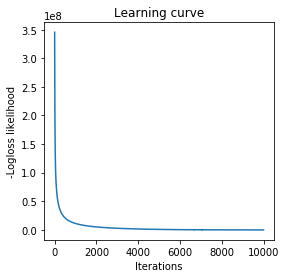

In [16]:
# Put the rest of your code and analysis for Part 3 here.
window = [5 ,10]  
exp_1 = df_cap.ewm(span=window[0],adjust=False).mean()
exp_2 = df_cap.ewm(span=window[1],adjust=False).mean()

exp_1  = exp_1/mean_df_cap
exp_1 /= exp_1.loc[exp_1.first_valid_index()]
exp_2   = exp_2/mean_df_cap
exp_2  /= exp_2.loc[exp_2.first_valid_index()]
exp_1_refined = exp_1.pct_change(periods=1).shift(-1)
exp_2_refined  = exp_2.pct_change(periods=1).shift(-1)
x2,z21,z22 = organize(df_cap_scaled,exp_1_refined, exp_2_refined)
expy_new=np.exp(x2)
exp2y_new=np.exp(2*x2)
results2, mean2, loss2 = model(X=x2, signal1=z21, signal2=z22, e1=expy_new, e2=exp2y_new, lr=0.0001)

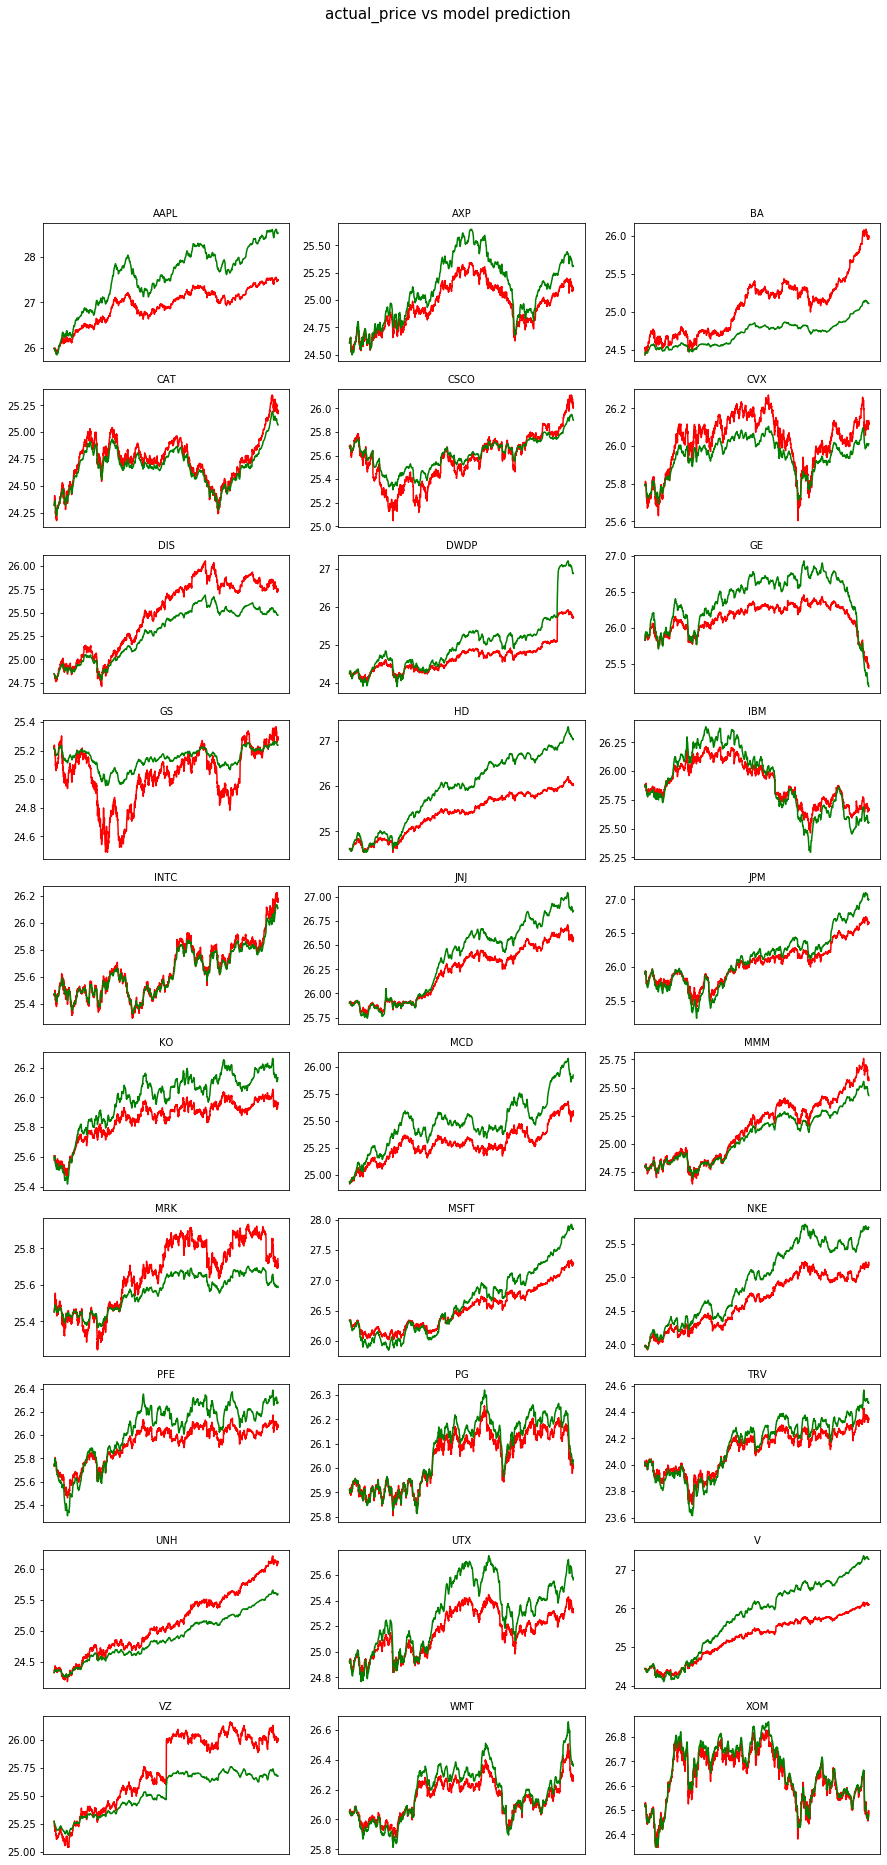

In [17]:
compare_plots(df_cap, mean2)

Here we create a new model that uses exponential weighted mean as input signal.

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [25]:
# show pca 
import datetime
asset_returns = df_cap.pct_change(axis='rows').dropna()

normed_returns = (asset_returns - asset_returns.mean())/asset_returns.std()


normed_returns.columns

Index(['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS',
       'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT',
       'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM'],
      dtype='object')

In [26]:
train_end = datetime.datetime(2015, 1, 1) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

In [27]:
import sklearn.decomposition
import seaborn as sns

stock_tickers = normed_returns.columns

n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix

if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns

    cov_matrix = df_train[stock_tickers].cov()
    cov_matrix_raw = df_raw_train[stock_tickers].cov()
    
    pca = sklearn.decomposition.PCA().fit(cov_matrix)
   
   
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

11 components explain 80.00% of variance


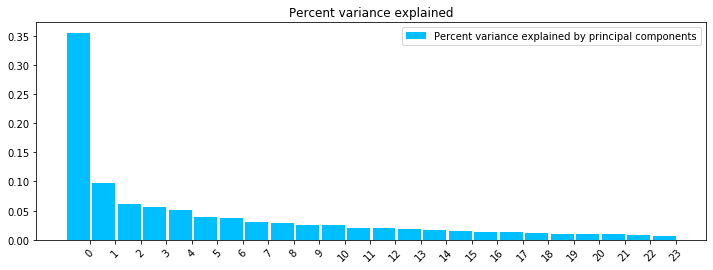

In [28]:
if pca is not None:
    bar_width = 0.9
    n_asset = int((8 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

if pca is not None:
    projected = pca.fit_transform(cov_matrix)

Sum of weights of first eigen-portfolio: 100.00


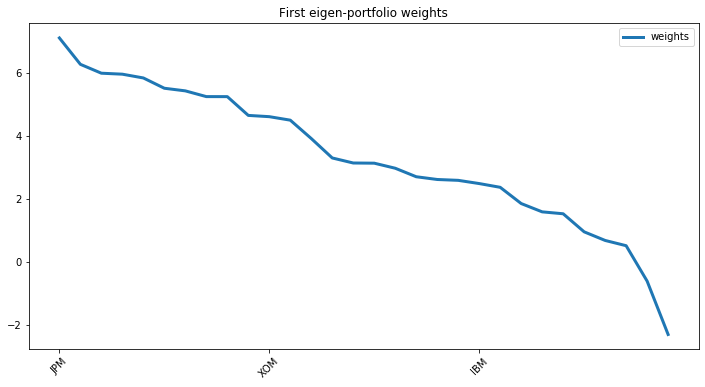

In [29]:
pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
if pca is not None:
    pcs = pca.components_

    best_weight_total = pcs[0,:].sum()
    # normalized to 1 
    pc_w = pcs[0,:]/best_weight_total
    
    eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights', 
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

In [30]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.

    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std()*np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return/annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

First eigen-portfolio:
Return = 0.27%
Volatility = 0.56%
Sharpe = 0.49


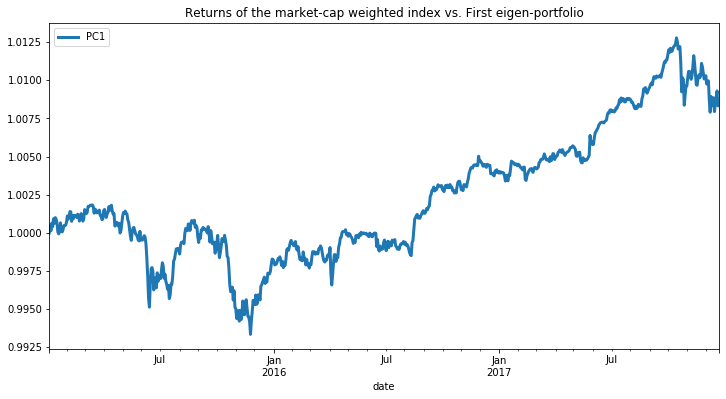

In [31]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)